###  YOU DO NOT NEED TO RUN THE BOX THAT SAYS "generate points.csv"
#### That box is only for transforming the points from the raw LIDAR data
If you accidentally run it, just cancel the process and continue

In [1]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import laspy, lazrs
import random as random
import networkx as nx
from scipy import spatial
from pathlib import Path

# file paths and names
data_dir = "data"
subsets_dir = "subsets"
random_points_name = "random_points"
path_points_name = "path_points"
path_name = "path"
path_i_name = "path_i"
subset_name = "subset"

random_points_path = os.path.join(data_dir, f"{random_points_name}.csv")
path_points_path = os.path.join(data_dir, f"{path_points_name}.csv")
path_path = os.path.join(data_dir, f"{path_name}.csv")
path_i_path = os.path.join(data_dir, f"{path_i_name}.csv")
subsets_path = os.path.join(subsets_dir, f"{subset_name}")

In [2]:
# generate points.csv | DO NOT NEED TO RUN THIS
x_offset = -12333899.21
y_offset = 4636564.89
z_offset = 1365.4
file_path = os.path.join("data", "point_cloud.laz")
las = laspy.read(file_path)
points = pd.DataFrame(np.vstack((las.x, las.y, las.z)).transpose())
points.columns = ["x", "y", "z"]
for i in range (points.shape[0]):
    points.at[i, "x"] -= x_offset
    points.at[i, "y"] -= y_offset
    points.at[i, "z"] -= z_offset
# points.to_csv("points.csv", index=False)
# z is the height

sorted_points = points.sort_values(by=['x', 'y', 'z'])
sorted_points = sorted_points.reset_index(drop=True)
sorted_points.to_csv("points.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'data/point_cloud.laz'

In [3]:
# randomize points.csv | DO NOT NEED TO RUN THIS
points = pd.read_csv("points.csv")
points.sample(frac=1).reset_index(drop=True).to_csv("random_points.csv", index=False)

In [3]:
points = pd.read_csv(random_points_path)

In [4]:
# generate a random point from the "points" dataframe
minDistance = 800
start_index = random.randint(0, points.shape[0])
end_index = random.randint(0, points.shape[0])
start = points.loc[start_index]
end = points.loc[end_index]

# get the distance between two points
def distance(p1, p2):
    return math.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2 + (p1.z - p2.z)**2)

while (distance(start, end) < minDistance):
    start_index = random.randint(0, points.shape[0])
    end_index = random.randint(0, points.shape[0])
    start = points.loc[start_index]
    end = points.loc[end_index]

print("Start point: ", start["x"], start["y"], start["z"])
print("End point: ", end["x"], end["y"], end["z"])
print("Start index: ", str(start_index))
print("End index: ", str(end_index))

Start point:  460.10000000149006 149.7600000007078 5.759999999999991
End point:  1534.9700000006703 514.9900000002235 5.730000000000018
Start index:  2805742
End index:  9791745


In [13]:
# Hyperparameters and variables

# number of edges per node in the graph
depth = 4

# number of subsets/subgraphs (ideally subsets == resolution)
subsets = 300

# higher resolution = less points. effective resolution = subsets/resolution
resolution = 5000

# max tolerated slope angle (degrees)
max_slope = 40

# slope importance factor
slope_factor = 0.005

# height importance factor
height_factor = 1000

# heuristic function: greater return value means greater cost for the path (best path has low cost)
def heur(x1, y1, z1, x2, y2, z2):
    # print(f"distance weight: {math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)}")
    # print(f"slope angle: {slope_angle(x1, y1, z1, x2, y2, z2)}")
    # print(f"slope weight: {slope_factor * slope_angle(x1, y1, z1, x2, y2, z2)}")
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2 + height_factor * (z2 - z1) ** 2)
    #  + slope_factor * slope_angle(x1, y1, z1, x2, y2, z2)

def heur_dist(x1, y1, z1, x2, y2, z2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# other variables
skip = len(points) // subsets
print(f"number of points per subset: {skip}")
print(f"effective resolution: {subsets/resolution}")
print(f"number of subsets: {subsets}")

# plot variables
boldness = 1
plotSize = 10

# helper methods
def slope_angle(x1, y1, z1, x2, y2, z2):
    # v dot w = |v||w|cos(theta)
    # theta = arccos(v dot w / |v||w|)
    v = np.array([abs(x2 - x1), abs(y2 - y1), abs(z2 - z1)])
    w = np.array([0, 0, 1])
    v_norm = np.linalg.norm(v)
    if v_norm == 0:
        return 0
    return abs(math.degrees(math.acos(np.dot(v, w) / v_norm)))

number of points per subset: 37205
effective resolution: 0.06
number of subsets: 300


In [14]:
skip = len(points) // subsets  # Number of points per subset
points_per_subset = len(points) // resolution  # Number of points per subset based on resolution

giant = []

for i in range(subsets):
    # Select the subset of points with points_per_subset points
    sub = points.iloc[i * points_per_subset:(i + 1) * points_per_subset].copy()
    
    # Add the start and end points to the subset
    sub = pd.concat([sub, start.to_frame().T, end.to_frame().T], ignore_index=True)
    
    giant.append(sub)


In [ ]:
path_points = pd.DataFrame(columns=["x", "y", "z"])
path_points = path_points._append(start)
# Define the heuristic function for A*
def heuristic1(node1, node2):
    x1, y1, z1 = G.nodes[node1]['x'], G.nodes[node1]['y'], G.nodes[node1]['z']
    x2, y2, z2 = G.nodes[node2]['x'], G.nodes[node2]['y'], G.nodes[node2]['z']
    return heur_dist(x1, y1, z1, x2, y2, z2)

for k in range(subsets):
    sub = giant[k]

    G = nx.Graph()

    # Add nodes from subset
    for i, row in sub.iterrows():
        G.add_node(i, x = row['x'], y = row['y'], z = row['z'])

    # Add edges between the closest nodes (ignoring height)
    coords = sub[['x', 'y']].values
    tree = spatial.KDTree(coords)
    for i, row in sub.iterrows():
        distances, indices = tree.query([row['x'], row['y']], k=depth+1)
        for j in range(1, len(indices)):  # skip the first index because it is the point itself
            G.add_edge(i, indices[j], weight=distances[j])

    # check if the graph is connected
    if not nx.is_connected(G):
        # start at a node. add an edge to the closest node that is not connected
        # repeat until the graph is connected
        start_node = sub.shape[0] - 2
        end_node = sub.shape[0] - 1
        while not nx.has_path(G, start_node, end_node):
            # find the closest node that is not connected
            for i, row in sub.iterrows():
                if not nx.has_path(G, start_node, i):
                    w = math.sqrt((sub.loc[start_node, 'x'] - sub.loc[i, 'x'])**2 + (sub.loc[start_node, 'y'] - sub.loc[i, 'y'])**2)
                    G.add_edge(start_node, i, weight=w)
                    break

    # Find the shortest path using A*
    path = nx.astar_path(G, sub.shape[0] - 2, sub.shape[0] - 1, heuristic=heuristic1)
    path = pd.Series(path)
    
    # add path to path_points
    path_points = pd.concat([path_points, sub.loc[path]])

print("\nDone")

/var/folders/nj/3217hbg559b0blsl1jfx56tw0000gn/T/ipykernel_6064/2212756663.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  path_points = path_points._append(start)



Done


In [16]:
path_points.drop_duplicates(inplace=True, keep='first')
path_points.reset_index(drop=True, inplace=True)
# add end point to path_points
path_points = path_points._append(end, ignore_index=True)
path_points.to_csv("path_points.csv", index=False)
print(path_points)

             x       y      z
0       460.10  149.76   5.76
1       472.18  168.83   4.65
2       465.20  195.00   7.31
3       486.04  221.45   6.91
4       496.39  247.84  11.42
...        ...     ...    ...
11816  1444.64  538.13   4.75
11817  1471.23  535.84   4.80
11818  1490.24  519.69   5.11
11819  1519.28  504.80   5.23
11820  1534.97  514.99   5.73

[11821 rows x 3 columns]


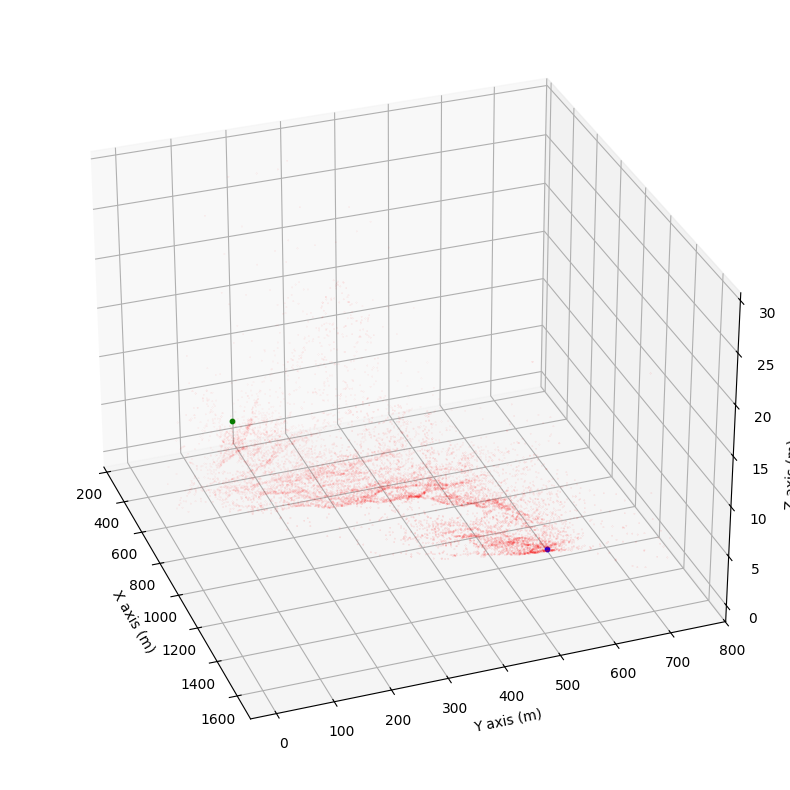

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(path_points["x"], path_points["y"], path_points["z"], c='r', s=boldness/subsets)

# plot start and end points
ax.scatter(start["x"], start["y"], start["z"], c='g', s=boldness*10)
ax.scatter(end["x"], end["y"], end["z"], c='b', s=boldness*10)

ax.set_xlabel('X axis (m)')
ax.set_ylabel('Y axis (m)')
ax.set_zlabel('Z axis (m)')
plt.rcParams["figure.figsize"] = (plotSize, plotSize)
ax.view_init(elev=30, azim=-20)
plt.show()

In [21]:
print("Finding path for path_points")
# make new graph using path_points
G = nx.Graph()

# Define the heuristic function for A*
def heuristic2(node1, node2):
    x1, y1, z1 = G.nodes[node1]['x'], G.nodes[node1]['y'], G.nodes[node1]['z']
    x2, y2, z2 = G.nodes[node2]['x'], G.nodes[node2]['y'], G.nodes[node2]['z']
    return heur(x1, y1, z1, x2, y2, z2)

# Add nodes from path_points
for i, row in path_points.iterrows():
    G.add_node(i, x = row['x'], y = row['y'], z = row['z'])

# Add edges between the closest nodes
coords = path_points[['x', 'y', 'z']].values
tree = spatial.KDTree(coords)
for i, row in path_points.iterrows():
    distances, indices = tree.query([row['x'], row['y'], row['z']], k=depth+1)
    for j in range(1, len(indices)):  # skip the first index because it is the point itself
        node1 = i
        node2 = indices[j]
        G.add_edge(node1, node2, weight=heuristic2(node1, node2))

# check if the graph is connected
if not nx.is_connected(G):
    print(f"Graph is not connected. Adding edges to connect the graph")
    # start at a node. add an edge to the closest node that is not connected
    # repeat until the graph is connected
    start_node = path_points.shape[0] - 2
    end_node = path_points.shape[0] - 1
    while not nx.has_path(G, start_node, end_node):
        # find the closest node that is not connected
        for i, row in path_points :
            if not nx.has_path(G, start_node, i):
                w = heuristic2(start_node, i)
                G.add_edge(start_node, i, weight=w)
                break

# Find the shortest path using A*
path = nx.astar_path(G, 0, path_points.shape[0] - 1, heuristic=heuristic2)
path = pd.Series(path)
print("\nDone")

Finding path for path_points
Graph is not connected. Adding edges to connect the graph

Done


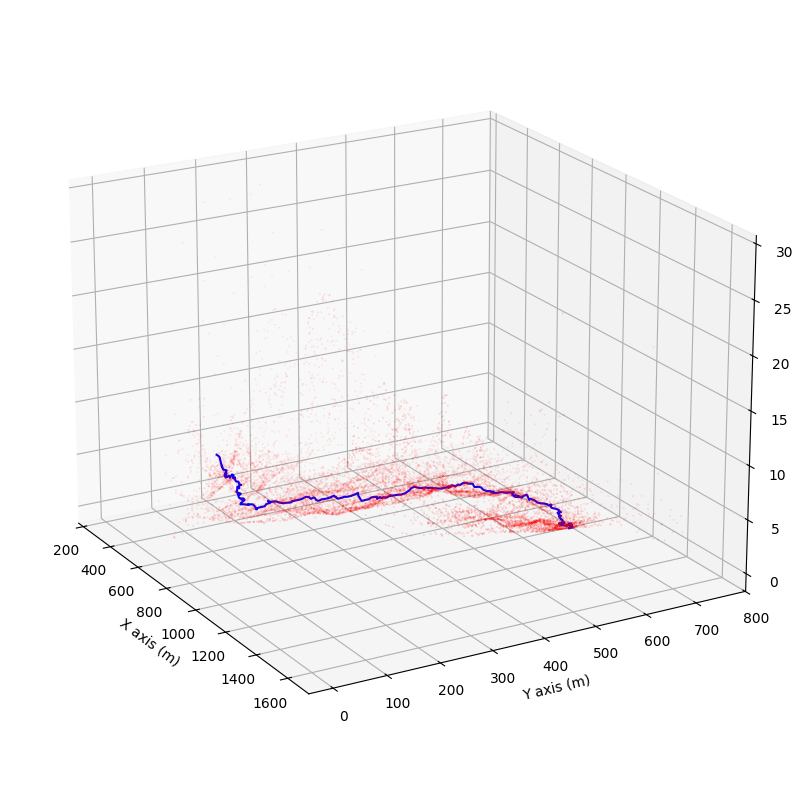

In [25]:
# plot the path
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(path_points["x"], path_points["y"], path_points["z"], c='r', s=2*boldness/subsets)
ax.plot(path_points.loc[path]["x"], path_points.loc[path]["y"], path_points.loc[path]["z"], c='b')
ax.set_xlabel('X axis (m)')
ax.set_ylabel('Y axis (m)')
ax.set_zlabel('Z axis (m)')
plt.rcParams["figure.figsize"] = (plotSize, plotSize)
ax.view_init(elev=20, azim=-30)
plt.show()

In [ ]:
# print the path
print(path_points.loc[path])

In [61]:
# print the weights of each edge in the path
total_weight = 0
for i in range(1, len(path)):
    total_weight += G[path[i-1]][path[i]]['weight']
    print(f"Edge {path[i-1]} -> {path[i]}: {G[path[i-1]][path[i]]['weight']}")

Edge 0 -> 61847: 5.102254404222373
Edge 61847 -> 29111: 6.722633412650983
Edge 29111 -> 77752: 3.8896015225982907
Edge 77752 -> 6395: 2.438565151447048
Edge 6395 -> 151928: 3.2072729849584394
Edge 151928 -> 31615: 2.2158519803007186
Edge 31615 -> 45921: 1.5200328946826631
Edge 45921 -> 14959: 3.813305652673931
Edge 14959 -> 103243: 3.364996285122495
Edge 103243 -> 38993: 2.7438112181756695
Edge 38993 -> 150229: 3.906980932193932
Edge 150229 -> 145901: 6.730148586628986
Edge 145901 -> 96038: 13.710335517409648
Edge 96038 -> 59789: 6.11816966092144
Edge 59789 -> 126168: 2.8440991544093603
Edge 126168 -> 56205: 1.270787157508148
Edge 56205 -> 153555: 2.2371857322098303
Edge 153555 -> 106182: 2.3967686574186886
Edge 106182 -> 138129: 1.6206788701368688
Edge 138129 -> 83689: 2.196360625677509
Edge 83689 -> 6905: 1.472548811620177
Edge 6905 -> 155284: 3.169621428422029
Edge 155284 -> 11969: 1.5086417736927291
Edge 11969 -> 37394: 1.9559141083070535
Edge 37394 -> 27136: 1.4597602540438974
Edg